# Home Insurance Modelling

This notebook contains the model development undertaken for the task of modelling lapsed policies in home insurance.

In [1]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from bayes_opt import BayesianOptimization

import time
import random

random.seed(42)

# Prepare data for binary classifcation

In [2]:
# Drop the raw POL_STATUS field as we don't need it for binary classification
training_df = pd.read_csv("../Data/Modelling_data/training_data.csv").drop(columns=['POL_STATUS'])
val_df = pd.read_csv("../Data/Modelling_data/val_data.csv").drop(columns=['POL_STATUS'])
test_df = pd.read_csv("../Data/Modelling_data/test_data.csv").drop(columns=['POL_STATUS'])

training_df = training_df.sample(frac=1, random_state=1).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)
training_df.head(10)

,QUOTE_YEAR,QUOTE_MONTH,QUOTE_DAY,COVER_YEAR,COVER_MONTH,COVER_DAY,DOB_YEAR,DOB_MONTH,DOB_DAY,QUOTE_TO_COVER_DAYS,...,HOME_EM_ADDON_PRE_REN,HOME_EM_ADDON_POST_REN,GARDEN_ADDON_PRE_REN,GARDEN_ADDON_POST_REN,KEYCARE_ADDON_PRE_REN,KEYCARE_ADDON_POST_REN,HP2_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,LABEL
0,1992,11,5,2006,2,1,1939,2,28,4836,...,1,0,0,0,0,0,0,0,226.46,1
1,2007,11,23,2007,12,12,1925,12,16,19,...,0,0,0,0,0,0,0,0,54.23,0
2,1992,11,5,2006,12,1,1937,3,24,5139,...,0,0,0,0,0,0,0,0,123.73,0
3,1992,11,5,2007,2,1,1951,2,25,5201,...,1,0,0,0,0,0,1,0,441.97,0
4,1992,11,5,2002,1,31,1942,3,5,3374,...,1,0,0,0,1,1,1,1,237.65,1
5,2007,12,8,2008,1,13,1940,9,28,36,...,0,0,0,0,0,0,1,1,217.89,0
6,1992,11,5,2010,12,1,1942,6,6,6600,...,0,0,1,1,0,0,0,0,231.20,1
7,2008,2,4,2008,2,8,1927,2,8,4,...,0,0,0,0,0,0,0,0,51.94,0
8,1992,11,5,2001,2,14,1931,1,6,3023,...,0,0,0,0,0,0,0,0,302.60,1
9,1992,11,5,2002,1,20,1933,12,29,3363,...,0,0,0,0,0,0,0,0,54.75,0


In [3]:
# These fields will need to be encoded before they can be used
string_cols = ['P1_EMP_STATUS','P1_MAR_STATUS','P1_SEX','PAYMENT_METHOD']

In [4]:
# get_dummies will one-hot encode the string columns for us
# as these columns have fairly low cardinality the number of columns will not grow too much

print(len(list(training_df.columns)))
print(len(list(val_df.columns)))
print(len(list(test_df.columns)))

x_train = pd.get_dummies(training_df, columns=string_cols)
x_val = pd.get_dummies(val_df, columns=string_cols)
x_test = pd.get_dummies(test_df, columns=string_cols)

# obtain training labels
y_train, y_val, y_test = x_train.pop('LABEL'), x_val.pop('LABEL'), x_test.pop('LABEL')

# one of the encoded columns is not present in the test data as there are no instances of P1_EMP_STATUS=C
# add this back in and rearrange the other dataframes 
x_test['P1_EMP_STATUS_C'] = 0
x_train = x_train[[c for c in x_train if c != 'P1_EMP_STATUS_C'] + ['P1_EMP_STATUS_C']]
x_val = x_val[[c for c in x_val if c != 'P1_EMP_STATUS_C'] + ['P1_EMP_STATUS_C']]

print(len(list(x_train.columns)))
print(len(list(x_val.columns)))
print(len(list(x_test.columns)))

52
52
52
74
74
74


In [5]:
# Finally we can normalise the data according to the training data and experiment with both unnormalised and normalised data
# This is so that we do not introduce any knowledge of the distribution of future data in the initial training
# MinMaxScaler helps preserve 0 values and sparsity

print(x_train.head(5))

scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train_norm = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
x_val_norm = pd.DataFrame(scaler.transform(x_val), columns = x_val.columns)
x_test_norm = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

print(x_train_norm.head(5))

   QUOTE_YEAR  QUOTE_MONTH  QUOTE_DAY  COVER_YEAR  COVER_MONTH  COVER_DAY  \
0        1992           11          5        2006            2          1   
1        2007           11         23        2007           12         12   
2        1992           11          5        2006           12          1   
3        1992           11          5        2007            2          1   
4        1992           11          5        2002            1         31   

   DOB_YEAR  DOB_MONTH  DOB_DAY  QUOTE_TO_COVER_DAYS  ...  P1_MAR_STATUS_P  \
0      1939          2       28                 4836  ...                0   
1      1925         12       16                   19  ...                0   
2      1937          3       24                 5139  ...                1   
3      1951          2       25                 5201  ...                1   
4      1942          3        5                 3374  ...                0   

   P1_MAR_STATUS_S  P1_MAR_STATUS_W  P1_SEX_F  P1_SEX_M  P1_SEX_N  \

# Logistic regression

The first model to try will be a logistic regression model. Logistic regression is a typical supervised learning algorithm for binary classification, using the sigmoid function y = 1/(1 + exp(-x)) to return an output probability for the positive class. This probability is then transformed to a classification based on a prior threshold. Here we will assume that a probability of >=0.5 is a prediction for the positive class.

In [6]:
# logistic regression model with slightly altered default parameters
lr_model = LogisticRegression(max_iter=1000, verbose=0)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
# Define various metrics for performance
def performance_metrics(data, labels, model, model_name):
    preds = model.predict(data)
    accuracy = metrics.accuracy_score(labels, preds)
    precision = metrics.precision_score(labels, preds)
    recall = metrics.recall_score(labels, preds)
    f1 = metrics.f1_score(labels, preds)
    mcc = metrics.matthews_corrcoef(labels, preds)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1: {:.2f}".format(f1))
    print("MCC: {:.2f}".format(mcc))
    target_names = ['Not lapsed', 'Lapsed']
    print(metrics.classification_report(labels, preds, target_names=target_names))
    metrics.plot_roc_curve(model, data, labels) 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('{} ROC Curve'.format(model_name))
    plt.rcParams["figure.figsize"] = [6.4, 4.8]
    plt.show()

Accuracy: 0.56
Precision: 0.69
Recall: 0.00
F1: 0.00
MCC: 0.02
              precision    recall  f1-score   support

  Not lapsed       0.55      1.00      0.71      8666
      Lapsed       0.69      0.00      0.00      6959

    accuracy                           0.56     15625
   macro avg       0.62      0.50      0.36     15625
weighted avg       0.61      0.56      0.40     15625



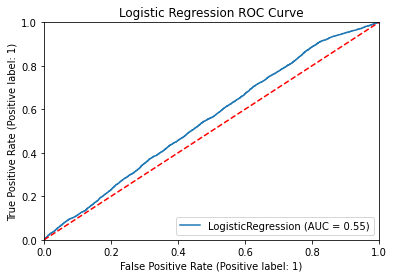

In [10]:
performance_metrics(data=x_test, labels=y_test, model=lr_model, model_name="Logistic Regression")

It does not look like this model is good at predicting the positive class. Medium-high precision but 0 recall implies that the model is very rarely predicting a lapsed case, and when it does predict lapsed it is correct a fairly high proportion of the time.

Perhaps the normalised data will perform better?

Accuracy: 0.61
Precision: 0.64
Recall: 0.28
F1: 0.39
MCC: 0.19
              precision    recall  f1-score   support

  Not lapsed       0.60      0.87      0.71      8666
      Lapsed       0.64      0.28      0.39      6959

    accuracy                           0.61     15625
   macro avg       0.62      0.58      0.55     15625
weighted avg       0.62      0.61      0.57     15625



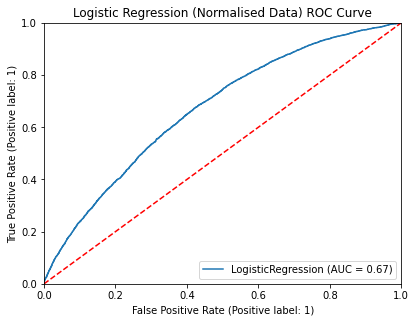

In [11]:
# Perform model training and inference with the normalised data

lr_model_norm = LogisticRegression(max_iter=1000, verbose=0)
lr_model_norm.fit(x_train_norm,y_train)

performance_metrics(data=x_test_norm, labels=y_test, model=lr_model_norm, model_name="Logistic Regression (Normalised Data)")

It appears that the normalised data provides an immediate uplift in the performance of the model, boosting metrics across the board. However, this model is still struggling to pick up instances of the positive class. Moving forward, we will stick to using the normalised dataset only.

# Random forest

Random forests are a popular tree-based method, utilising an ensemble of decision trees in parallel in order to average out the predictions from individual trees on subsets of the data. Some hyperparameters include:
* n_estimators, the number of trees in the forest
* max_depth, the max depth of each tree
* max_samples, the max number of samples to draw from the data for each tree
* max_features, the max number of features picked randomly in each tree

In [12]:
# Random forest model with slightly altered default parameters, using the normalised data
rf_model = RandomForestClassifier(max_depth=6, random_state=1, verbose=0)
rf_model.fit(x_train_norm, y_train)

RandomForestClassifier(max_depth=6, random_state=1)

Accuracy: 0.56
Precision: 0.85
Recall: 0.02
F1: 0.03
MCC: 0.07
              precision    recall  f1-score   support

  Not lapsed       0.56      1.00      0.72      8666
      Lapsed       0.85      0.02      0.03      6959

    accuracy                           0.56     15625
   macro avg       0.71      0.51      0.37     15625
weighted avg       0.69      0.56      0.41     15625



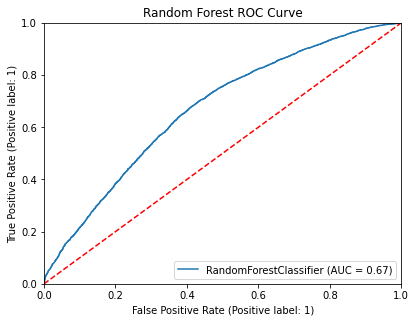

In [13]:
# make predictions for test data and show various metrics
performance_metrics(data=x_test_norm, labels=y_test, model=rf_model, model_name="Random Forest")

This model appears to be worse than the logistic regression at predicting the positive class. High precision but very low recall implies that the model is very rarely predicting a lapsed case, but when it does predict lapsed it is highly likely to be correct.

# XGBoost

XGBoost is an extremely powerful gradient boosting technique, utilising decision trees in series instead of in parallel in random forests. Each tree seeks to minimise the error from the tree before it. Some hyperparameters include:
* learning rate, the rate at which the model learns and makes adjustments to its weights
* n_estimators, the number of trees used to train the model
* max_depth, the max depth of each tree
* colsample_bytree, the subsample ratio of columns when constructing each tree
* min_child_weight, the weight needed in a child in order to further partition the tree

We will again train with the basic xgboost model. However this time we will also look at the log-loss curve, evaluated using the validation data, to get more of an understanding as to the performance of the model.

In [14]:
xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=1)
eval_set = [(x_train_norm, y_train), (x_val_norm, y_val)]
xgb_model.fit(x_train_norm, y_train, eval_metric = "logloss", eval_set=eval_set, verbose=0)

C:\Users\user\Documents\Python\advent-of-code-2020\advent-of-code\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

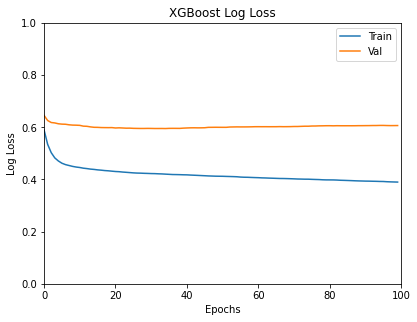

Accuracy: 0.63
Precision: 0.61
Recall: 0.44
F1: 0.51
MCC: 0.23
              precision    recall  f1-score   support

  Not lapsed       0.63      0.78      0.70      8666
      Lapsed       0.61      0.44      0.51      6959

    accuracy                           0.63     15625
   macro avg       0.62      0.61      0.60     15625
weighted avg       0.62      0.63      0.62     15625



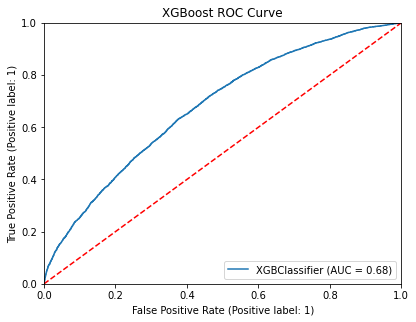

In [19]:
# make predictions for test data
def loss_curve(model, model_name):
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(6.4,4.8))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
    ax.legend()
    
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.xlim([0.0, epochs])
    plt.ylim([0.0, 1.0])
    plt.title('{} Log Loss'.format(model_name))
    plt.show()

loss_curve(model=xgb_model, model_name="XGBoost")
performance_metrics(data=x_test_norm, labels=y_test, model=xgb_model, model_name="XGBoost")

This model appears to perform the best, with the largest F1 and MCC scores, as well as AUC. However it is still not super-performant. The slight discrepancy in training and validation loss could be indicative of overfitting, although both losses are very low. In addition, the validation loss appears to start increasing slightly after a certain number of epochs (number of trees used). We can see which features the model thinks are most important:

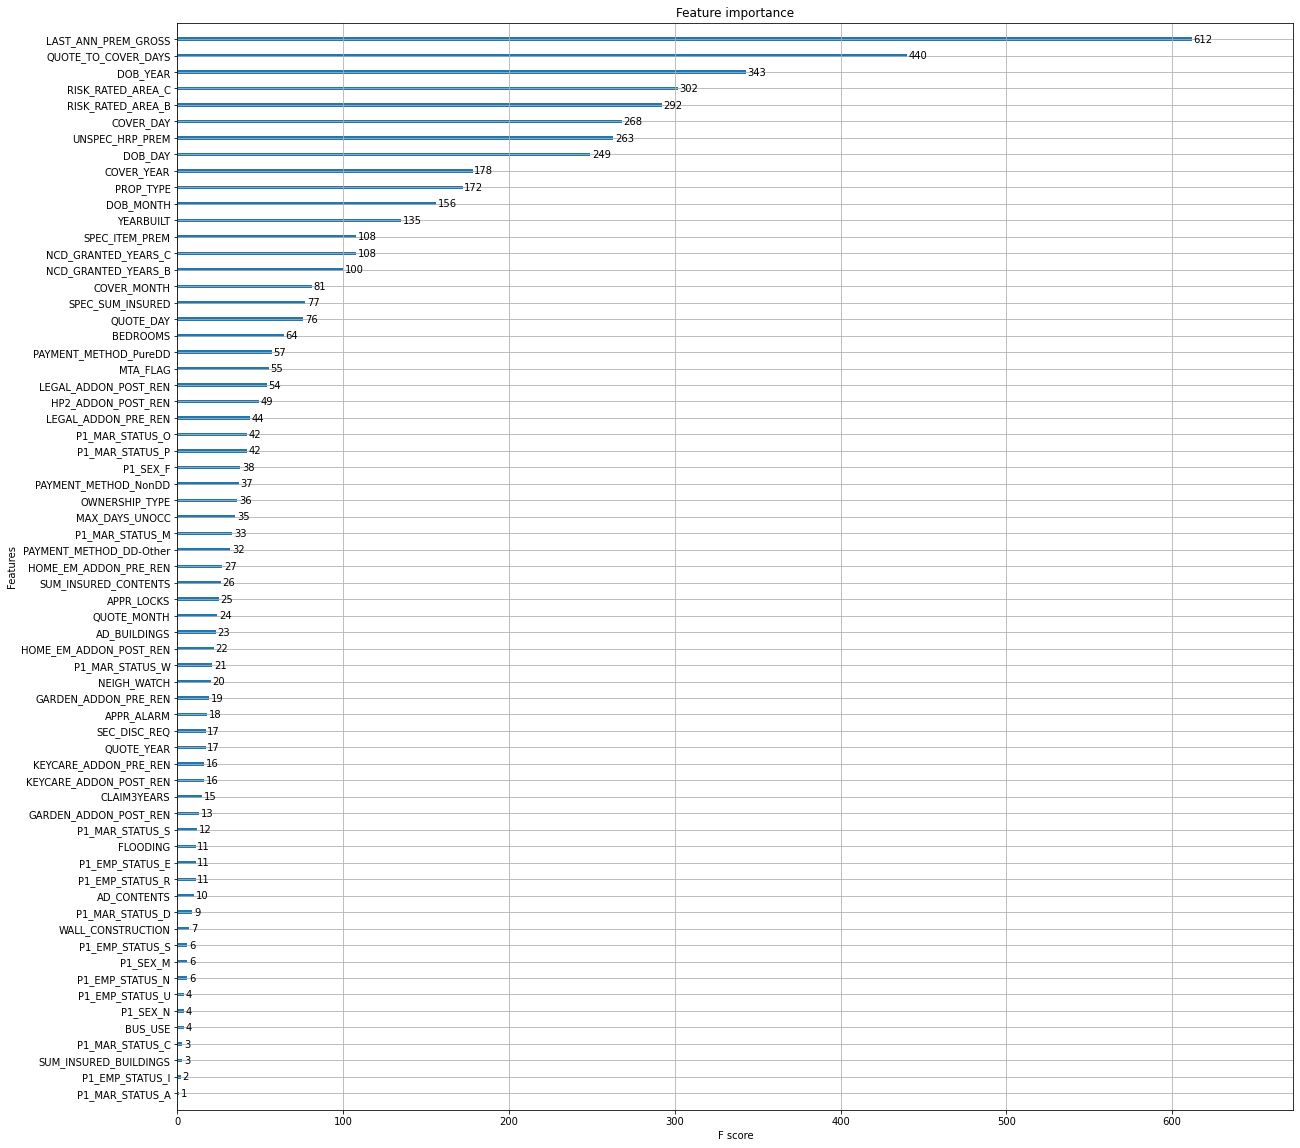

In [17]:
xgboost.plot_importance(xgb_model)
plt.rcParams["figure.figsize"] = [20,20]
plt.show()

The most important features include LAST_ANN_PREM_GROSS, QUOTE_TO_COVER_DAYS, and information about the date of birth and date of the start of coverage. Interestingly a lot of features have very little importance, including a lot of the one-hot encoded features, suggesting that we might be using too many features and thus overfitting. We will now train on a subset of the most important features, and also reduce the number of trees used.

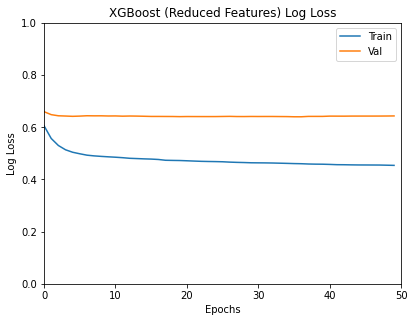

Accuracy: 0.58
Precision: 0.55
Recall: 0.27
F1: 0.37
MCC: 0.12
              precision    recall  f1-score   support

  Not lapsed       0.59      0.82      0.68      8666
      Lapsed       0.55      0.27      0.37      6959

    accuracy                           0.58     15625
   macro avg       0.57      0.55      0.53     15625
weighted avg       0.57      0.58      0.54     15625



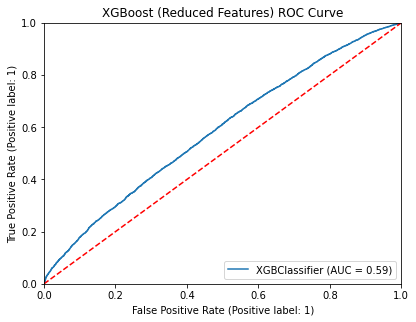

In [20]:
trunc_columns = ["LAST_ANN_PREM_GROSS", "QUOTE_TO_COVER_DAYS", "DOB_YEAR", "DOB_DAY", "RISK_RATED_AREA_B", 
                 "RISK_RATED_AREA_C","COVER_DAY", "UNSPEC_HRP_PREM", "DOB_MONTH", "PROP_TYPE", "COVER_YEAR", "YEARBUILT", 
                 "SPEC_ITEM_PREM","NCD_GRANTED_YEARS_C","NCD_GRANTED_YEARS_B", "COVER_MONTH", "SPEC_SUM_INSURED", 
                 "QUOTE_DAY", "BEDROOMS"]

x_train_trunc, x_val_trunc, x_test_trunc = x_train_norm[trunc_columns], x_val_norm[trunc_columns], x_test_norm[trunc_columns]

xgb_trunc = xgboost.XGBClassifier(n_estimators=50, objective="binary:logistic", random_state=1, use_label_encoder=False)
eval_set = [(x_train_trunc, y_train), (x_val_trunc, y_val)]
xgb_trunc.fit(x_train_trunc, y_train, eval_metric = "logloss", eval_set=eval_set, verbose=0)

loss_curve(model=xgb_trunc, model_name="XGBoost (Reduced Features)")
performance_metrics(data=x_test_trunc, labels=y_test, model=xgb_trunc, model_name="XGBoost (Reduced Features)")

Whilst the log loss curves haven't changed too much, the metrics have deteriorated, so we will continue to use the full dataset. The last thing we will try is some hyperparameter tuning on some of the parameters to see if we can get some increases in performance.

# Hyperparameter Tuning

Hyperparameter tuning attempts to find the optimal hyperparameters for a model. We will now tune the XGBoost model to find the optimal parameters for learning rate, max_depth, colsample_bytree, min_child_weight, gamma (minimum loss reduction to make another partition on the tree), and reg_lambda (l2 regularisation).

There are several methods for hyperparameter tuning:
* Random search, where random hyperparameters from an initial set are chosen until an optimal set is reached after a certain number of iterations;
* Grid search, where a search is conducted over all combinations of initial hyperparameters given to find the optimal set;
* Bayesian optimisation, utilising knowledge of previous iterations to weight areas in the hyperparameter space to try.

We will use Bayesian optimisation as it balances the robustness of a full grid search with the speed of a random search, and can be configured to favour one or the other more. We will maximise the performance with respect to the mcc, and initialise with some fairly high values for random exploration and bayesian exploration.

In [21]:
bayes_params = {"init_points": 50, "n_iter": 10} # init_points is num steps of random exploration, n_iter is num steps of Bayes
hypertune_params = {"learning_rate": [0.01, 1],
                    "max_depth": [6, 10],
                    "colsample_bytree": [0.5, 1], 
                    "min_child_weight": [1, 10],
                   "gamma": [0, 10],
                   "reg_lambda": [1, 10]} # boundaries for hyperparameters

In [26]:
# Define the function that returns the value we wish to maximise, i.e. define the model training
def xgb_eval(learning_rate=0.01, max_depth=6, colsample_bytree=0.5, min_child_weight=1, gamma=0, reg_lambda=1):
    params = {}
    params["learning_rate"] = learning_rate
    params["max_depth"] = int(round(max_depth, 0))
    params["colsample_bytree"] = colsample_bytree
    params["min_child_weight"] = min_child_weight
    params["gamma"] = gamma
    params["reg_lambda"] = reg_lambda
    
    xgb_candidate = xgboost.XGBClassifier(**params, n_estimators=50, objective="binary:logistic", random_state=1, 
                                          use_label_encoder=False)
    xgb_candidate.fit(x_train_norm, y_train, eval_metric = "logloss", eval_set=[(x_val_norm, y_val)], verbose=0)
    
    mcc = metrics.matthews_corrcoef(y_val, xgb_candidate.predict(x_val_norm))
    print("MCC: {:.4f}".format(mcc))
    print("Params: {}".format(str(params)))
    print("===============================================================================================================")
    return np.max(mcc)
    

In [27]:
# Initialise and execute Bayesian optimisation
start = time.time()
optimiser = BayesianOptimization(xgb_eval, hypertune_params, random_state=1, verbose=0)
optimiser.maximize(**bayes_params)
best_params = optimiser.max["params"]
print("Best MCC: {:.4f}".format(optimiser.max["target"]))
print("Best params: {}".format(str(best_params)))
print("Total time: {:.2f}s".format(time.time() - start))

MCC: 0.2167
Params: {'learning_rate': 0.010113231069171438, 'max_depth': 7, 'colsample_bytree': 0.7085110023512871, 'min_child_weight': 2.3208030173540175, 'gamma': 7.203244934421581, 'reg_lambda': 1.8310473529191802}
MCC: 0.2557
Params: {'learning_rate': 0.40279979948836325, 'max_depth': 8, 'colsample_bytree': 0.5931301056888354, 'min_child_weight': 4.772750629629654, 'gamma': 3.4556072704304777, 'reg_lambda': 7.166975503570836}
MCC: 0.2258
Params: {'learning_rate': 0.0371137172659469, 'max_depth': 9, 'colsample_bytree': 0.6022261248657588, 'min_child_weight': 4.755743221304143, 'gamma': 8.781174363909454, 'reg_lambda': 6.028208456011765}
MCC: 0.2361
Params: {'learning_rate': 0.8027371229887813, 'max_depth': 10, 'colsample_bytree': 0.5701934692976169, 'min_child_weight': 3.8208176034331855, 'gamma': 1.981014890848788, 'reg_lambda': 7.230903541023826}
MCC: 0.2494
Params: {'learning_rate': 0.09419376925608013, 'max_depth': 6, 'colsample_bytree': 0.9381945761480192, 'min_child_weight': 2

MCC: 0.2332
Params: {'learning_rate': 0.9703197891974292, 'max_depth': 9, 'colsample_bytree': 0.5977147405546595, 'min_child_weight': 3.1586298323282755, 'gamma': 5.813589272732578, 'reg_lambda': 5.4439274284185695}
MCC: 0.2696
Params: {'learning_rate': 0.16522348069962345, 'max_depth': 6, 'colsample_bytree': 0.8099778591906899, 'min_child_weight': 1.630199293473001, 'gamma': 8.289808995501787, 'reg_lambda': 5.3771059984332865}
MCC: 0.2786
Params: {'learning_rate': 0.3241887852289392, 'max_depth': 10, 'colsample_bytree': 0.8031647308266652, 'min_child_weight': 6.217706973212172, 'gamma': 5.688514370864813, 'reg_lambda': 4.421270553611953}
MCC: 0.2712
Params: {'learning_rate': 0.6725405645186527, 'max_depth': 7, 'colsample_bytree': 0.7754741095589484, 'min_child_weight': 1.5970135098559741, 'gamma': 7.453344309065021, 'reg_lambda': 4.330757781226957}
MCC: 0.2630
Params: {'learning_rate': 0.7552279982014257, 'max_depth': 6, 'colsample_bytree': 0.8148587535107823, 'min_child_weight': 3.34

MCC: 0.2747
Params: {'learning_rate': 0.6519124182403597, 'max_depth': 9, 'colsample_bytree': 0.7239420103709266, 'min_child_weight': 6.902004385010851, 'gamma': 9.795927832603283, 'reg_lambda': 7.6111926796878775}
MCC: 0.2675
Params: {'learning_rate': 1.0, 'max_depth': 8, 'colsample_bytree': 0.7056314271868885, 'min_child_weight': 7.35628196861231, 'gamma': 10.0, 'reg_lambda': 6.088060213927549}
MCC: 0.2699
Params: {'learning_rate': 0.42759814525919415, 'max_depth': 10, 'colsample_bytree': 0.5, 'min_child_weight': 6.379013492726012, 'gamma': 9.043518281553318, 'reg_lambda': 9.852637465653286}
MCC: 0.2677
Params: {'learning_rate': 0.3612940652664374, 'max_depth': 9, 'colsample_bytree': 0.8059753837894521, 'min_child_weight': 7.232351831054546, 'gamma': 2.8219538615262625, 'reg_lambda': 8.736626055502546}
MCC: 0.2495
Params: {'learning_rate': 1.0, 'max_depth': 6, 'colsample_bytree': 0.5, 'min_child_weight': 8.813693264459651, 'gamma': 9.459575524724524, 'reg_lambda': 5.392309916184918}


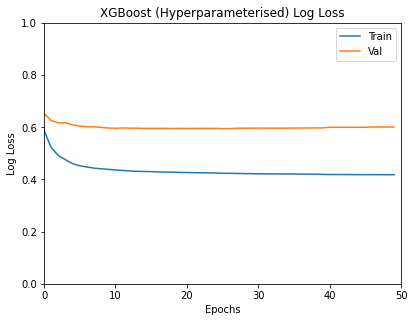

Accuracy: 0.63
Precision: 0.60
Recall: 0.53
F1: 0.56
MCC: 0.25
              precision    recall  f1-score   support

  Not lapsed       0.65      0.72      0.68      8666
      Lapsed       0.60      0.53      0.56      6959

    accuracy                           0.63     15625
   macro avg       0.63      0.62      0.62     15625
weighted avg       0.63      0.63      0.63     15625



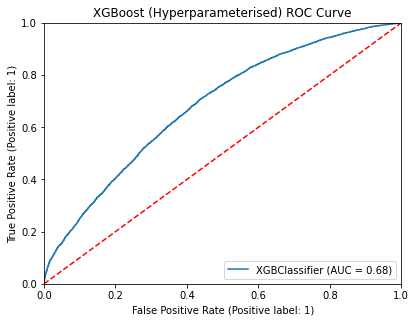

In [28]:
# Use optimised hyperparameters and obtain predictions and metrics on test set
best_params["max_depth"] = int(round(best_params["max_depth"],0))
eval_set = [(x_train_norm, y_train), (x_val_norm, y_val)]
xgb_hyp = xgboost.XGBClassifier(**best_params, n_estimators = 50, objective="binary:logistic", random_state=1, 
                                use_label_encoder=False)
xgb_hyp.fit(x_train_norm, y_train, eval_metric = "logloss", eval_set=eval_set, verbose=0)

loss_curve(model=xgb_hyp, model_name="XGBoost (Hyperparameterised)")
performance_metrics(data=x_test_norm, labels=y_test, model=xgb_hyp, model_name="XGBoost (Hyperparameterised)")

We see that the hyperparameterised XGBoost model performs the best out of all the models. However the uplift in performance from the regular XGBoost model is still minimal, and in particular the MCC score is still quite bad. Having tried 3 different models now, it would be worth looking back into the data for further improvements to performance.